In [1]:
# Standard library imports
import os
import json
import sys
import re
import concurrent.futures
from typing import List, Dict, Any, Tuple, TypedDict, Annotated, Optional , Literal

# Third-party imports
import boto3
import fitz
import requests
from bs4 import BeautifulSoup
from opensearchpy import OpenSearch, RequestsHttpConnection
from pydantic import BaseModel, Field, ValidationError
from IPython.display import Image

# LangChain core imports
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableLambda
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langchain_core.tools import tool
from langchain.schema import BaseRetriever, Document

# LangGraph imports
from langgraph.graph import StateGraph, add_messages, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# LangChain AWS imports
from langchain_aws import ChatBedrockConverse, BedrockEmbeddings

# LangChain experimental imports
from langchain_experimental.tools.python.tool import PythonAstREPLTool

# LangChain community imports
from langchain_community.tools.tavily_search import TavilySearchResults

# Operator imports
from operator import itemgetter

from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

In [8]:
def visualize(graph):
    display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
    )

In [22]:
# 서브그래프 생성
class SubState(TypedDict):
    messages: Annotated[list, add_messages]
    num_add: int

# 서브그래프 노드 1 생성
def subgraph_n1(state: SubState):
    current_messages = state["messages"]
    current_num = state["num_add"]
    print("checkone-> Current messages:", current_messages)
    print(f"subgraph_n1: Current num_add = {current_num}")
    
    return {
        "messages": [AIMessage(content="반갑습니다")], 
        "num_add": current_num + 1
    }

# 서브그래프 노드 2 생성
def subgraph_n2(state: SubState):
    current_messages = state["messages"]
    current_num = state["num_add"]
    
    print(f"subgraph_n2: Current num_add = {current_num}")
    print("checktwo-> Current messages:", current_messages)
    
    return {
        "messages": [AIMessage(content="무엇을 원하세요")], 
        "num_add": current_num + 1
    }

# 서브그래프 생성
subgraph_builder = StateGraph(SubState)
subgraph_builder.add_node("subgraph_n1", subgraph_n1)
subgraph_builder.add_node("subgraph_n2", subgraph_n2)
subgraph_builder.add_edge(START, "subgraph_n1")
subgraph_builder.add_edge("subgraph_n1", "subgraph_n2")
subgraph_builder.add_edge("subgraph_n2", END)
subgraph = subgraph_builder.compile()




In [23]:
# 상위 그래프 생성
class ParentState(TypedDict):
    messages_top: Annotated[list, add_messages]
    num_add: int
    
# 상위 그래프 노드 1 생성
def node_1(state: ParentState):
    current_messages = state["messages_top"]
    current_num = state["num_add"]
    return {
        "messages_top": [AIMessage(content="빅뱅의 거짓말입니다")], 
        "num_add": current_num + 1
    }


In [28]:
# 상위 그래프와 하위 그래프를 연결하는 그래프 생성
def subgraph_wrapper(state: ParentState):
    # ParentState 에서  SubState 변환
    sub_state = {
        "messages": state["messages_top"].copy(),
        "num_add": state["num_add"]
    }
    
    # 서브그래프 실행
    sub_result = subgraph.invoke(sub_state)
    
    #parent 안에 없는 메세지만 발췌
    parent_messages = state["messages_top"].copy()
    for msg in sub_result["messages"]:
        if msg not in parent_messages:
            parent_messages.append(msg)
    
    return {
        "messages_top": parent_messages,
        "num_add": sub_result["num_add"]
    }

#라우터 생성
def is_music_query(state: ParentState) -> str:
    """
    Check if the latest message is about music.
    If it's about music, route to END, otherwise to node_2 (subgraph).
    """
    if not state["messages_top"]:
        return "node_2"  
    
    #최근 메시지 가져오기
    last_message = state["messages_top"][-2]
    print("check check -> ", last_message)
    # 사람 메세지인지 아닌지 확인
    if last_message.type == "human":
        print("end point")
        content = last_message.content.lower()
        
        # 음악 관련질문인지 확인
        music_keywords = ["music", "song", "singer", "concert", "album", "playlist", 
                         "음악", "노래", "가수", "콘서트", "앨범", "플레이리스트"]
        
        # 종료
        if any(keyword in content for keyword in music_keywords):
            print("Music query detected! Routing to END")
            return "END"
    
    # 서브그래프로 이동
    print("Non-music query. Routing to subgraph")
    return "node_2"


In [29]:
# Create the parent graph with conditional routing
builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", subgraph_wrapper)  # Use the wrapper function

# node1 연결
builder.add_edge(START, "node_1")
# routing 설정 
builder.add_conditional_edges("node_1", 
                              is_music_query, 
                             {
                                 "END": END,
                                 "node_2": "node_2"
                             }
                             )
# node2 연결
builder.add_edge("node_2", END)

# Compile the graph
graph = builder.compile()



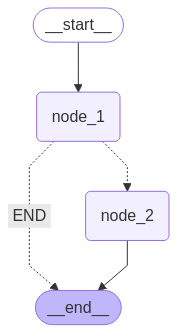

In [30]:
visualize(graph)

In [31]:
music_result = graph.invoke({
    "messages_top": [HumanMessage(content="음악")],
    "num_add": 0
})

print("\nMusic Query Result:")
print(f"num_add: {music_result['num_add']}")
print("Messages:")
for msg in music_result["messages_top"]:
    print(f"{msg.type}: {msg.content}")


check check ->  content='음악' additional_kwargs={} response_metadata={} id='2d40ade8-8b19-4b5e-a2a5-77d864196ebb'
end point
Music query detected! Routing to END

Music Query Result:
num_add: 1
Messages:
human: 음악
ai: 빅뱅의 거짓말입니다


In [32]:
# Test with a non-music query
non_music_result = graph.invoke({
    "messages_top": [HumanMessage(content="오늘 날씨 어때요?")],
    "num_add": 0
})

print("\nNon-Music Query Result:")
print(f"num_add: {non_music_result['num_add']}")
print("Messages:")
for msg in non_music_result["messages_top"]:
    print(f"{msg.type}: {msg.content}")


check check ->  content='오늘 날씨 어때요?' additional_kwargs={} response_metadata={} id='ab27b341-ef7c-496e-84a1-1a2ac60c81c5'
end point
Non-music query. Routing to subgraph
checkone-> Current messages: [HumanMessage(content='오늘 날씨 어때요?', additional_kwargs={}, response_metadata={}, id='ab27b341-ef7c-496e-84a1-1a2ac60c81c5'), AIMessage(content='빅뱅의 거짓말입니다', additional_kwargs={}, response_metadata={}, id='d334717c-5847-4299-9f1e-ad7139f30697')]
subgraph_n1: Current num_add = 1
subgraph_n2: Current num_add = 2
checktwo-> Current messages: [HumanMessage(content='오늘 날씨 어때요?', additional_kwargs={}, response_metadata={}, id='ab27b341-ef7c-496e-84a1-1a2ac60c81c5'), AIMessage(content='빅뱅의 거짓말입니다', additional_kwargs={}, response_metadata={}, id='d334717c-5847-4299-9f1e-ad7139f30697'), AIMessage(content='반갑습니다', additional_kwargs={}, response_metadata={}, id='e1db57a5-7cf2-47e3-839a-0c54f490cbd0')]

Non-Music Query Result:
num_add: 3
Messages:
human: 오늘 날씨 어때요?
ai: 빅뱅의 거짓말입니다
ai: 반갑습니다
ai: 무엇을 원하세요
